In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import plotly.graph_objects as go
import re
import io

# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Patch
import plotly.io as pio

# Setting some parameters
warnings.filterwarnings("ignore")

# Import functions
sys.path.insert(1, str(here('bin')))
from customPalette import *

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

overwriteFigures = True
overwriteData = True

pd.options.display.max_columns = 300
pd.options.display.max_rows = 1000

**Defining functions**

In [2]:
print("Main directory path: {}".format(here()))

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-R1


In [3]:
#### We want to explore data characteristics ACROSS only MAIN? also VALDIATION / EXCLUDED / EXTERNAL?

**Load data**

In [4]:
# Load the annotated file
adata = sc.read_h5ad(here("01_data_processing/results/02_INFLAMMATION_external_afterQC.h5ad"))
adata.uns['log1p'] = dict()
adata.uns['log1p']['base'] = None # only if logscale is computed
adata

AnnData object with n_obs × n_vars = 572872 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'chemistry_colors', 'log1p'

In [6]:
len(adata.obs["patientID"].unique())

86

## Cell Exploration

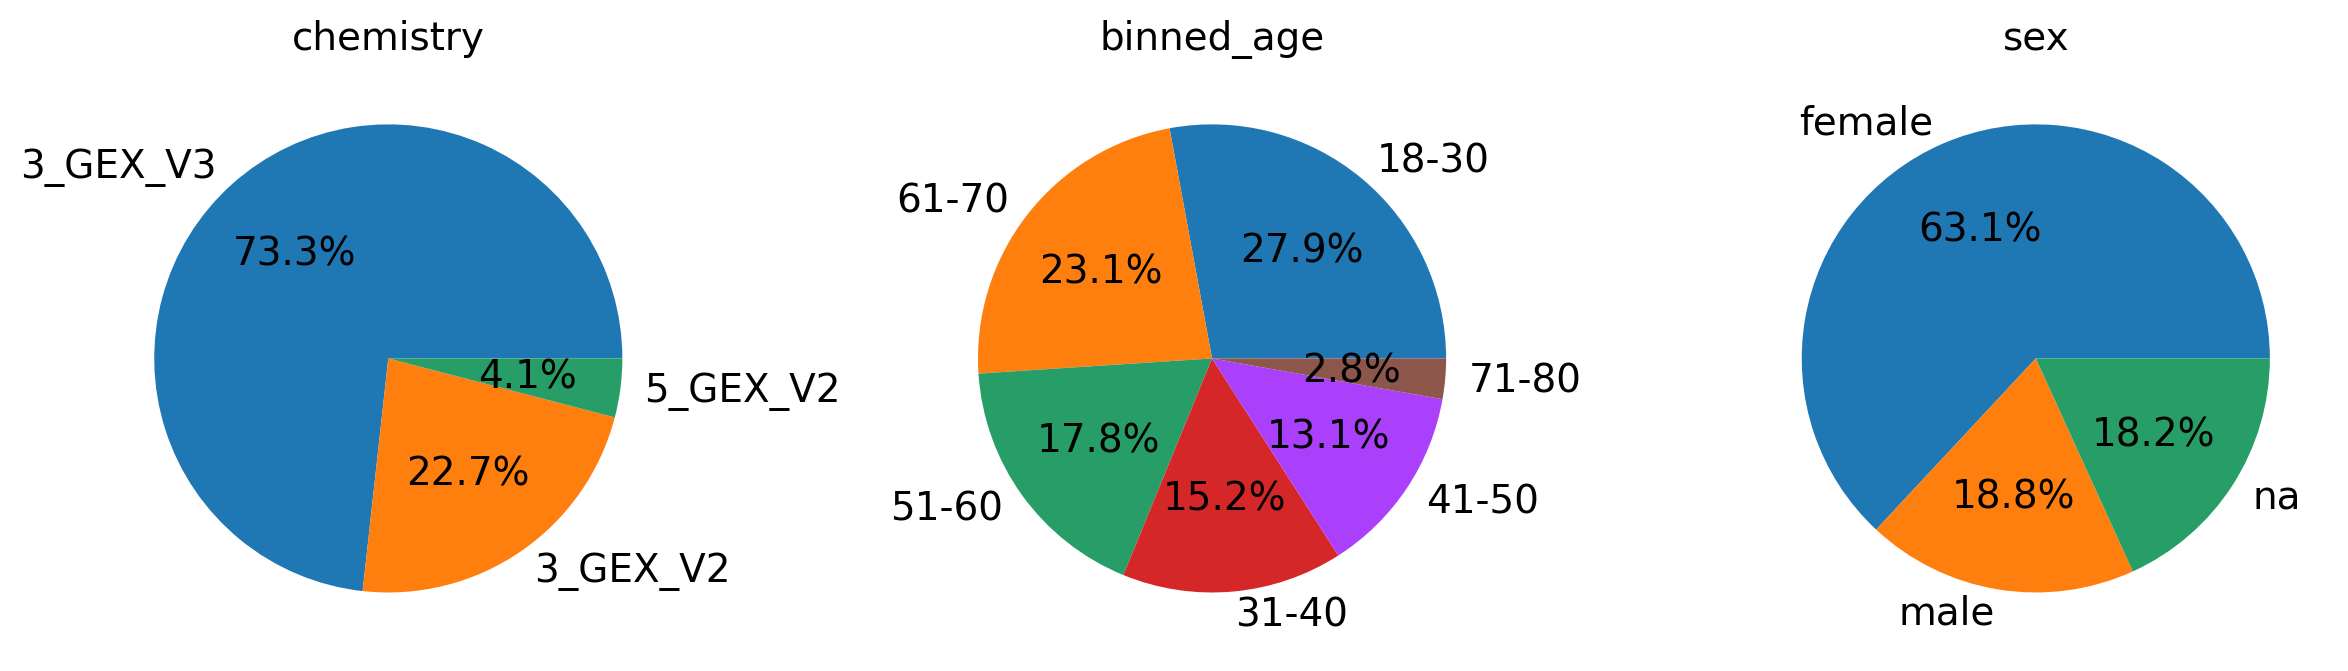

In [5]:
# PieChart for CHEMISTRY, BINNED_AGE and SEX

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Data for each value count
for i, variable in enumerate(["chemistry", "binned_age", "sex"]):
    counts = adata.obs[variable].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%')
    axes[i].set_title(variable)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

# Patient exploration

In [6]:
obs_df = adata.obs
obs_df = obs_df[['studyID', 'patientID', 'chemistry', 'technology', 'binned_age', 'sex', 'disease']].drop_duplicates() # removing LIBRARY (sampleID in multiple)
obs_df = obs_df.reset_index(drop=True)
obs_df["studyID_disease"] =  obs_df["disease"].str.cat(obs_df["studyID"], sep="_")
obs_df = obs_df.sort_values(by="studyID_disease")
obs_df.head()

,studyID,patientID,chemistry,technology,binned_age,sex,disease,studyID_disease
59,Martin2019,Martin2019_P15,3_GEX_V2,3_GEX_V2,NaN,na,CD,CD_Martin2019
58,Martin2019,Martin2019_P14,3_GEX_V2,3_GEX_V2,NaN,na,CD,CD_Martin2019
57,Martin2019,Martin2019_P12,3_GEX_V2,3_GEX_V2,NaN,na,CD,CD_Martin2019
56,Martin2019,Martin2019_P11,3_GEX_V2,3_GEX_V2,NaN,na,CD,CD_Martin2019
55,Martin2019,Martin2019_P10,3_GEX_V2,3_GEX_V2,NaN,na,CD,CD_Martin2019


In [7]:
obs_df['sex'] = pd.Categorical(obs_df['sex'], categories=['male', 'female'])
obs_df['binned_age'] = pd.Categorical(obs_df['binned_age'], categories=['<18',  '18-30', '31-40', '41-50', '51-60','61-70', '71-80', '>80', 'unknown'])
obs_df['binned_age'] = obs_df['binned_age'].fillna('unknown')

# Replace 
obs_df['studyID'] = obs_df['studyID'].replace('Zhang2023', 'Zhang2022')

obs_df['disease'] = obs_df['disease'].astype(str)
obs_df['patientID'] = obs_df['patientID'].astype(str)

# Calculate total patientID by disease
total_patientID_by_disease = obs_df.groupby('disease')['patientID'].count().reset_index()
total_patientID_by_disease.columns = ['disease', 'total_patientID']

# Merge total_patientID_by_disease back to obs_df
obs_df = pd.merge(obs_df, total_patientID_by_disease, on='disease')

# Mapping diseases to diseaseGroup
obs_df['diseaseGroup'] = obs_df['disease'].map(diseaseCategories)
obs_df['diseaseGroup'] = pd.Categorical(obs_df['diseaseGroup'], categories=diseaseGroup_sortednames, ordered=True)

# Sort obs_df by diseaseGroup in the order specified by diseaseGroup_sortednames, and then by total_patientID ascending
obs_df = obs_df.sort_values(by=['diseaseGroup', 'total_patientID'], ascending=[True, False])

# Convert disease to categorical with the correct order
obs_df['disease'] = pd.Categorical(obs_df['disease'], categories=obs_df['disease'].unique())

# Reset index inplace
obs_df.reset_index(drop=True, inplace=True)


# Reset index inplace
obs_df.reset_index(drop=True, inplace=True)

In [8]:
# Helper function to calculate percentages
def calculate_percentage(df, group_by_cols):
    count_data = df.groupby(group_by_cols).size().reset_index(name='Patient Count')
    total_counts = count_data.groupby(group_by_cols[0])['Patient Count'].transform('sum')
    count_data['Percentage'] = (count_data['Patient Count'] / total_counts) * 100
    return count_data

# Plotting function for stacked bar plots with percentages
def plot_percentage_stacked_bar(ax, x, y, data, title, palette, **kwargs):
    # Pivot the data
    pivot_data = data.pivot_table(index=y, columns=x, values='Percentage', fill_value=0)

    # Extract bar height from kwargs or set a default value
    bar_height = kwargs.pop('height', 0.8)

    # Plot the data with specified bar height
    left = np.zeros(len(pivot_data))
    legend_handles = []
    for column in pivot_data.columns:
        ax.barh(pivot_data.index, pivot_data[column], left=left, height=bar_height, label=column, color=palette[column], **kwargs)
        left += pivot_data[column]
        legend_handles.append(Patch(facecolor=palette[column], edgecolor='black', label=column))
        
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('' if ax != axes[0] else 'Disease')

    # Remove grid
    ax.tick_params(axis='both', which='both', length=0)
    ax.tick_params(axis='x', rotation=90)
    ax.yaxis.grid(False)

    # Set legend
    ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2, frameon=False, handles=legend_handles)

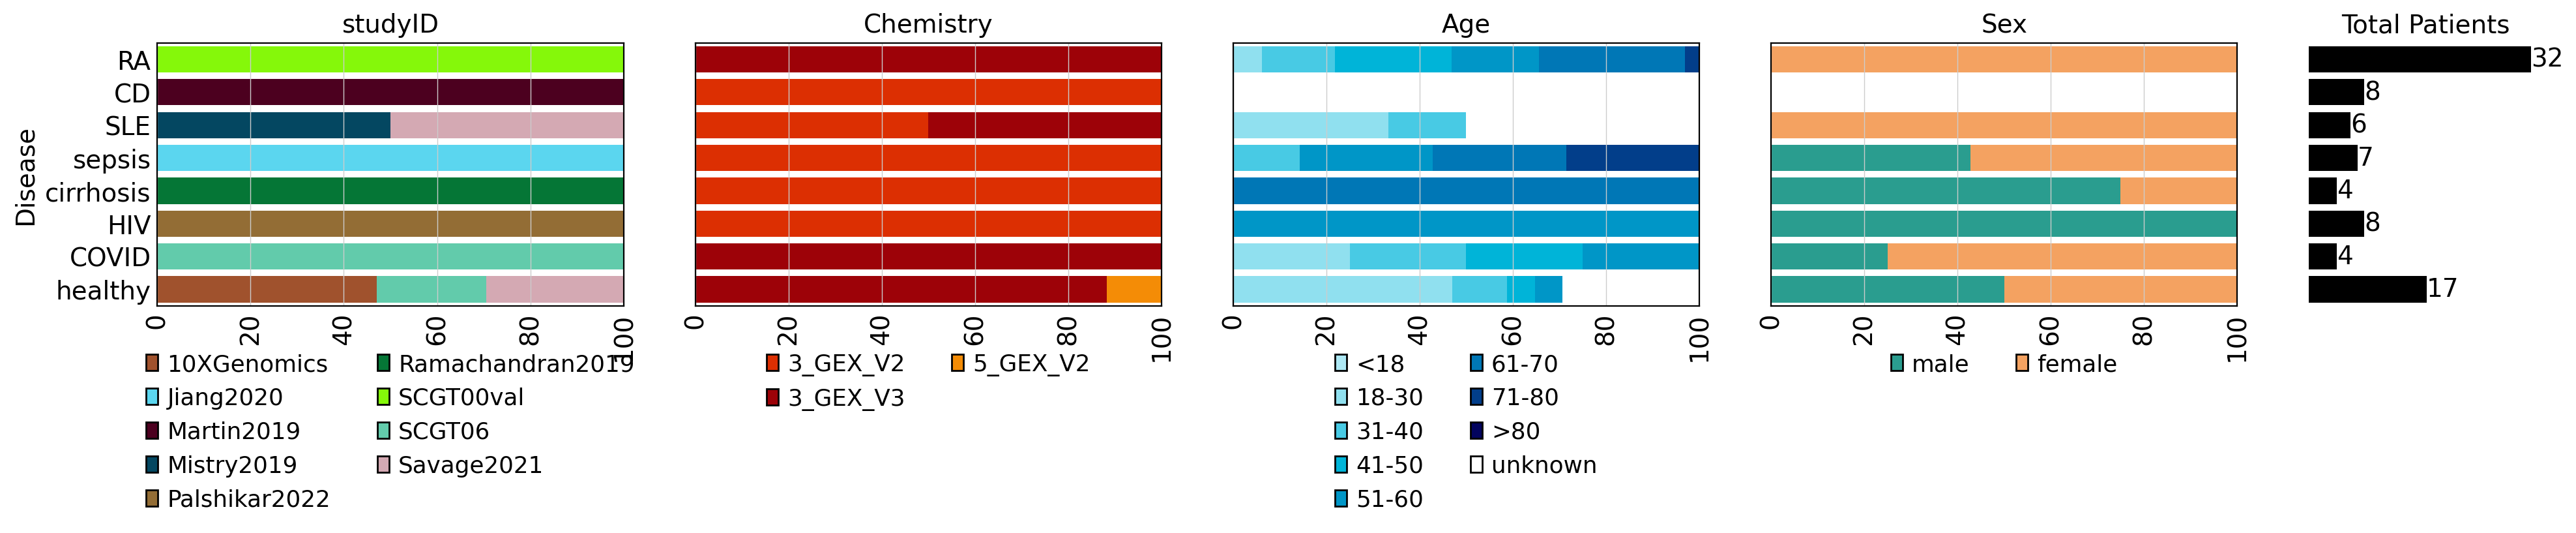

In [14]:
# Calculate percentages
agg_data_studyID = calculate_percentage(obs_df, ['disease', 'studyID'])
agg_data_chemistry = calculate_percentage(obs_df, ['disease', 'chemistry'])
agg_data_binned_age = calculate_percentage(obs_df, ['disease', 'binned_age'])
agg_data_sex = calculate_percentage(obs_df, ['disease', 'sex'])
total_per_disease = obs_df.groupby('disease').size().reset_index(name='Total Patients')

# Create a figure and subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4.5), sharey=True, 
                         gridspec_kw={'width_ratios': [3, 3, 3, 3, 1.5]})

# Plot stacked bar plots for each category
plot_percentage_stacked_bar(axes[0], 'studyID', 'disease', agg_data_studyID, 'studyID', palette=studyID_palette)
plot_percentage_stacked_bar(axes[1], 'chemistry', 'disease', agg_data_chemistry, 'Chemistry', palette=chemistry_palette)
plot_percentage_stacked_bar(axes[2], 'binned_age', 'disease', agg_data_binned_age, 'Age', palette=binned_age_palette)
plot_percentage_stacked_bar(axes[3], 'sex', 'disease', agg_data_sex, 'Sex', palette=sex_palette)

# Plot total patients per disease
sns.barplot(ax=axes[4], x='Total Patients', y='disease', data=total_per_disease, orient='h', color="black")
axes[4].set_title('Total Patients')
axes[4].bar_label(axes[4].containers[0])
axes[4].axis('off')

# Adjust layout
plt.tight_layout(w_pad=0, h_pad=0.1)
plt.show()

fig.savefig(here(f"01_data_processing/figures/EXTERNALdata_ClinicalMetadata_overview.pdf"),
dpi=300,
bbox_inches='tight',
pad_inches=0.1
)

In [ ]:
# For table

counts = obs_df[["disease", "binned_age", "sex"]].value_counts().reset_index(name='count').sort_values(by=['disease', 'binned_age'], ascending=[True, True])
pivot_table = counts.pivot_table(index='disease', columns=['binned_age', 'sex'], values='count') # , fill_value=0
pivot_table = pivot_table.reindex(disease_sortednames)
pivot_table

In [ ]:
obs_df = adata.obs
obs_df = obs_df[['studyID', 'patientID', 'chemistry', 'technology', 'binned_age', 'sex', 'disease']].drop_duplicates() # removing LIBRARY (sampleID in multiple)
obs_df = obs_df.reset_index(drop=True)
obs_df["studyID_disease"] =  obs_df["disease"].str.cat(obs_df["studyID"], sep="_")
obs_df = obs_df.sort_values(by="studyID_disease")
obs_df.head()

In [ ]:
counts = obs_df[["disease", "binned_age", "sex"]].value_counts().reset_index(name='count').sort_values(by=['disease', 'binned_age'], ascending=[True, True])
pivot_table = counts.pivot_table(index='disease', columns=['binned_age', 'sex'], values='count') # , fill_value=0
pivot_table = pivot_table.reindex(disease_sortednames)
pivot_table

In [ ]:
obs_df = adata.obs
obs_df = obs_df[['studyID', 'patientID', 'chemistry', 'technology', 'binned_age', 'sex', 'disease']].drop_duplicates() # removing LIBRARY (sampleID in multiple)
obs_df = obs_df.reset_index(drop=True)
obs_df["studyID_disease"] =  obs_df["disease"].str.cat(obs_df["studyID"], sep="_")
obs_df = obs_df.sort_values(by="studyID_disease")
obs_df.head()

In [ ]:
obs_df['sex'] = pd.Categorical(obs_df['sex'], categories=['male', 'female', 'unknown'])
obs_df['sex'] = obs_df['sex'].fillna('unknown')
obs_df['binned_age'] = pd.Categorical(obs_df['binned_age'], categories=['<18',  '18-30', '31-40', '41-50', '51-60','61-70', '71-80', '>80', 'unknown'])
obs_df['binned_age'] = obs_df['binned_age'].fillna('unknown')


counts = obs_df[["disease", "binned_age", "sex"]].value_counts().reset_index(name='count').sort_values(by=['disease', 'binned_age'], ascending=[True, True])
pivot_table = counts.pivot_table(index='disease', columns=['binned_age', 'sex'], values='count') # , fill_value=0
pivot_table = pivot_table.reindex(disease_sortednames)
pivot_table

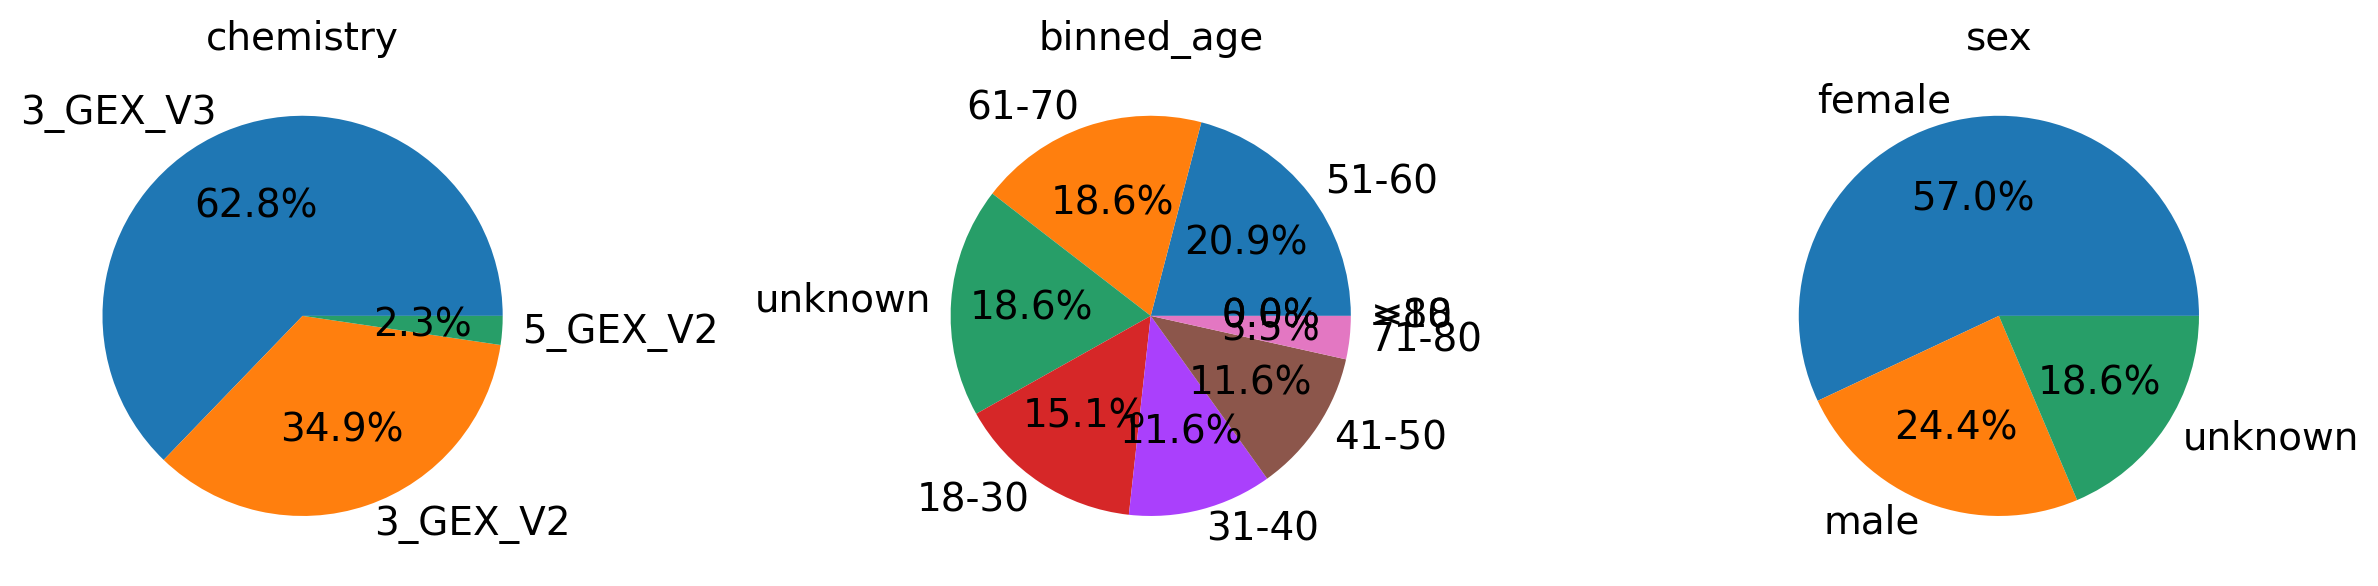

In [23]:
# PieChart for CHEMISTRY, BINNED_AGE and SEX

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Data for each value count
for i, variable in enumerate(["chemistry", "binned_age", "sex"]):
    counts = obs_df[variable].value_counts()
    axes[i].pie(counts, labels=counts.index, autopct='%1.1f%%')
    axes[i].set_title(variable)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [13]:
session_info.show()